Data Processing Notebook
===

Prepare data for the analysis. The raw data is downloaded from the FAIR Universe HiggsML challenge repository. Use the HiggsML package to download and process the dataset, followed by selections and saving to local cache.



In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mplhep as hep
import yaml
from utils import plot_kinematic_features

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from HiggsML.systematics import systematics
hep.style.use(hep.style.ATLAS)

from HiggsML.datasets import download_dataset

In [2]:
data = download_dataset("https://zenodo.org/records/15131565/files/FAIR_Universe_HiggsML_data.zip")

2025-08-08 18:58:24,279 - HiggsML.datasets     - INFO     - Handling as URL: https://zenodo.org/records/15131565/files/FAIR_Universe_HiggsML_data.zip
2025-08-08 18:58:24,280 - HiggsML.datasets     - INFO     - Current working directory: /home/jsandesara_umass_edu/NSBI-workflow-tutorial/FAIR_universe_Higgs_tautau
2025-08-08 18:58:24,292 - HiggsML.datasets     - INFO     - Total rows: 220099101
2025-08-08 18:58:24,292 - HiggsML.datasets     - INFO     - Test size: 66029730


## Configuration File Updates

At various points in this tutorial, we will update the `config.yml` file - this is important as the config file is our model that will be used for downstream training and inference.

The `yaml` file we use for config is human-readable and can thus be easily edited by hand, if you want to use the individual modules in the `nsbi-common-utils` package with your own analysis

In [3]:
config = {}

In [4]:
PATH_PREFIX = os.getcwd() + "/"
PATH_SAVED_DATA = PATH_PREFIX + "cached_data/"

config.update({
                "PATH_PREFIX" : PATH_PREFIX,
                "PATH_SAVED_DATA" : PATH_SAVED_DATA,
              })

In [5]:
if not os.path.exists(PATH_SAVED_DATA):
    print(f"Making new directory for caching data {PATH_SAVED_DATA}")
    os.makedirs(PATH_SAVED_DATA)

## Building The Model

Objective: Measure the inclusive $H\to \tau\tau$ cross-section.

\<TBA\>

Excluding diboson background

In [6]:
# Signal processes in the model
SIGNAL_PROCESSES = ["htautau"]

# Background processes in the model
BACKGROUND_PROCESSES = ["ttbar", "ztautau"]

# choice of reference hypothesis - will be discussed later
REFERENCE_PROCESSES = ["htautau", "ttbar"] 

config.update({
    "SIGNAL_PROCESSES": SIGNAL_PROCESSES,
    "BACKGROUND_PROCESSES": BACKGROUND_PROCESSES,
    "REFERENCE_PROCESSES": REFERENCE_PROCESSES,
})

In [7]:
# Assign an integer with each of the processes 
process_to_int_labels_dict = {
      "htautau" : 0,
      "ztautau" : 1,
      "ttbar" : 2,
}

config.update({
    "PROCESS_TO_INT_LABELS_DICT" : process_to_int_labels_dict
})

In [8]:
# Get the dictionary that assigns an integer with each of the processes
process_to_int_labels_dict = config["process_to_int_labels_dict"]
print(process_to_int_labels_dict)

{'htautau': 0, 'ztautau': 1, 'ttbar': 2}


In [9]:
list_of_processes = SIGNAL_PROCESSES + BACKGROUND_PROCESSES

In [10]:
data.load_train_set(train_size=0.35)
df_training_full = data.get_train_set()
del data

2025-08-08 18:58:33,706 - HiggsML.datasets     - INFO     - Selected train size: 53924279
2025-08-08 19:00:14,834 - HiggsML.datasets     - INFO     - Data loaded successfully


In [11]:
process_to_exclude = set(df_training_full.detailed_labels.unique()) - set(list_of_processes)
process_to_exclude = list(process_to_exclude)
print(process_to_exclude)

['diboson']


In [12]:
mask_process_exclusion = ~np.isin(df_training_full.detailed_labels, process_to_exclude)

df_training_full = df_training_full[mask_process_exclusion].copy()
df_training_full.detailed_labels.value_counts()

detailed_labels
ztautau    34427124
htautau    17849937
ttbar       1517440
Name: count, dtype: int64

In [13]:
n_ttbar = df_training_full.loc[
    df_training_full.detailed_labels=='ttbar'
].shape[0]

df_list = []
for _, df_process in df_training_full.groupby('detailed_labels'):
    weight_sum_orig = df_process.weights.sum()
    df_sampled = df_process.sample(n = n_ttbar, random_state=42)
    df_sampled['weights'] *= weight_sum_orig / df_sampled['weights'].sum()
    df_list.append(df_sampled)
    del df_sampled

df_training = pd.concat(df_list).reset_index(drop=True)
del df_training_full, df_list

In [14]:
df_training['type'] = df_training['detailed_labels'].copy()

In [15]:
mask_selected_processes = np.isin(df_training.detailed_labels.to_numpy(), list_of_processes)
df_training = df_training[mask_selected_processes].copy()

In [16]:
df_training.detailed_labels.unique()

array(['htautau', 'ttbar', 'ztautau'], dtype=object)

In [17]:
df_training['train_labels'] = -1 

for key in process_to_int_labels_dict:
    df_training.loc[df_training['detailed_labels'] == key, 'train_labels'] = process_to_int_labels_dict[key]


In [18]:
syst_settings = {
    'TES_up': {'tes': 1.02},
    'TES_dn': {'tes': 0.98},
    'JES_up': {'jes': 1.02},
    'JES_dn': {'jes': 0.98}
}



dataset_dict = {}

dataset_dict['nominal'] = systematics(
        data_set = df_training,
        dopostprocess=False
        )

for sample_name, syst_args in syst_settings.items():
    dataset_dict[sample_name] = systematics(
        data_set = df_training, 
        dopostprocess=False, 
        **syst_args
    )


## Feature selection

In [19]:
dataset_dict['nominal'].columns.unique()

Index(['PRI_lep_pt', 'PRI_lep_eta', 'PRI_lep_phi', 'PRI_had_pt', 'PRI_had_eta',
       'PRI_had_phi', 'PRI_jet_leading_pt', 'PRI_jet_leading_eta',
       'PRI_jet_leading_phi', 'PRI_jet_subleading_pt',
       'PRI_jet_subleading_eta', 'PRI_jet_subleading_phi', 'PRI_n_jets',
       'PRI_jet_all_pt', 'PRI_met', 'PRI_met_phi', 'weights',
       'detailed_labels', 'labels', 'DER_mass_transverse_met_lep',
       'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet',
       'DER_prodeta_jet_jet', 'DER_deltar_had_lep', 'DER_pt_tot', 'DER_sum_pt',
       'DER_pt_ratio_lep_had', 'DER_met_phi_centrality',
       'DER_lep_eta_centrality', 'type', 'train_labels'],
      dtype='object')

In [20]:
# Features to use for training NNs
TRAINING_FEATURES = ['DER_mass_transverse_met_lep',
       'log_DER_mass_vis', 'log_DER_pt_h', 'DER_deltar_had_lep', 'log_DER_pt_tot', 'log_DER_sum_pt',
       'DER_pt_ratio_lep_had', 'DER_met_phi_centrality']

# Features to standardize before training
TRAINING_FEATURES_TO_SCALE = ['DER_mass_transverse_met_lep',
       'log_DER_mass_vis', 'log_DER_pt_h', 'DER_deltar_had_lep', 'log_DER_pt_tot', 'log_DER_sum_pt',
       'DER_pt_ratio_lep_had', 'DER_met_phi_centrality']

config.update(
    {
        "TRAINING_FEATURES" : TRAINING_FEATURES,
        "TRAINING_FEATURES_TO_SCALE" : TRAINING_FEATURES_TO_SCALE,
    }
)

Selections & Feature Engineering
-

Preselect the dataset to remove phase space regions with low statistics

In [21]:
input_features_noJets = ['PRI_lep_pt', 'PRI_lep_eta', 'PRI_lep_phi', 'PRI_had_pt', 'PRI_had_eta',
       'PRI_had_phi', 'PRI_met', 'PRI_met_phi', 'DER_mass_transverse_met_lep',
       'DER_mass_vis', 'DER_pt_h', 'DER_deltar_had_lep', 'DER_pt_tot', 'DER_sum_pt',
       'DER_pt_ratio_lep_had', 'DER_met_phi_centrality']

input_features_1Jets = ['PRI_jet_leading_pt', 'PRI_jet_leading_eta',
       'PRI_jet_leading_phi',
       'PRI_jet_all_pt']

input_features_2Jets = ['PRI_jet_subleading_pt',
       'PRI_jet_subleading_eta', 'PRI_jet_subleading_phi', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet',
       'DER_prodeta_jet_jet',
       'DER_lep_eta_centrality']

input_features_by_jet = {1:input_features_1Jets, 2: input_features_2Jets}

input_features_nJets = ['PRI_n_jets', 'njet_0', 'njet_1', 'njet_2']

input_features = input_features_noJets + input_features_1Jets + input_features_2Jets + input_features_nJets

In [22]:
median_feature = {}

for feature in input_features_1Jets:

    median_feature[feature] = np.median(dataset_dict['nominal'].loc[dataset_dict['nominal']['PRI_n_jets'] >=1, feature])

for feature in input_features_2Jets:
    
    median_feature[feature] = np.median(dataset_dict['nominal'].loc[dataset_dict['nominal']['PRI_n_jets'] >=2, feature])
    

In [23]:
for sample, dataset in dataset_dict.items():

    mask_sel = (
        (dataset['DER_mass_transverse_met_lep'] <= 250.0) &
        (dataset['DER_mass_vis'] <= 500.0) &
        (dataset['DER_sum_pt'] <=1000) &
        (dataset['DER_pt_tot'] <=250) &
        (dataset['DER_deltar_had_lep'] <=4.5) &
        (dataset['DER_pt_h'] <=400) &
        (dataset['DER_pt_ratio_lep_had'] <= 9.0)
    )
    dataset = dataset[mask_sel].copy()
    
    dataset['njet_0'] = (dataset['PRI_n_jets'] == 0).astype(int)
    dataset['njet_1'] = (dataset['PRI_n_jets'] == 1).astype(int)
    dataset['njet_2'] = (dataset['PRI_n_jets'] >= 2).astype(int)

    for i, feat_list in input_features_by_jet.items():
        mask_i = (dataset['PRI_n_jets'] >= i).astype(float)
        dataset[f'jet{i}_mask'] = mask_i

        for feat in feat_list:
            dataset[feat] = dataset[feat].where(dataset['PRI_n_jets'] >= i, median_feature[feat])

    for feat in input_features.copy():

        kin = dataset[feat].to_numpy()
        
        if (np.amin(kin) > 0.0) and (np.amax(kin)>100):
            log_feat = 'log_'+feat
            dataset[log_feat] = np.log(kin+10.0)
            if log_feat not in input_features:
                input_features.append(log_feat)

    dataset_dict[sample] = dataset


In [24]:
# Select the subset of features to keep in the saved dataset - remove unnecessary data
columns_to_keep = input_features + ['weights', 'detailed_labels', 'type', 'train_labels',
                                   'jet1_mask', 'jet2_mask']

for sample in dataset_dict:
    dataset_dict[sample] = dataset_dict[sample][columns_to_keep].copy()

In [25]:
path_to_data_save = {}

# Save the datasets for training and inference
for sample in dataset_dict: 
    path_to_data_save[sample] = f"{PATH_SAVED_DATA}df_{sample}.h5"
    dataset_dict[sample].to_hdf(path_to_data_save[sample], key="dataset", mode="w")


In [7]:
config.update(
    {
        "Systematics": [
            {
                "Name"       : "TES",
                "weight_up"  : path_to_data_save["TES_up"],
                "weight_dn"  : path_to_data_save["TES_dn"],
                "Type"       : "NormPlusShape",
                "Samples"    : ["htautau", "ztautau", "ttbar"]
            },
            {
                "Name"       : "JES",
                "weight_up"  : path_to_data_save["JES_up"],
                "weight_dn"  : path_to_data_save["JES_dn"],
                "Type"       : "NormPlusShape",
                "Samples"    : ["htautau", "ztautau", "ttbar"]
            },
        ]
    }
)

In [8]:
# Save the updated YAML back to the file
with open('config.yml', 'w') as file:
    yaml.dump(
        config, file, 
        default_flow_style=False,
        sort_keys=False, indent=4, width=1000                 
             )

Visualize the data
-

Check for low-stats phase space and effect from systematics before moving to the density ratio training.

In [27]:
import sys, importlib
importlib.reload(sys.modules['utils'])
from utils import plot_kinematic_features

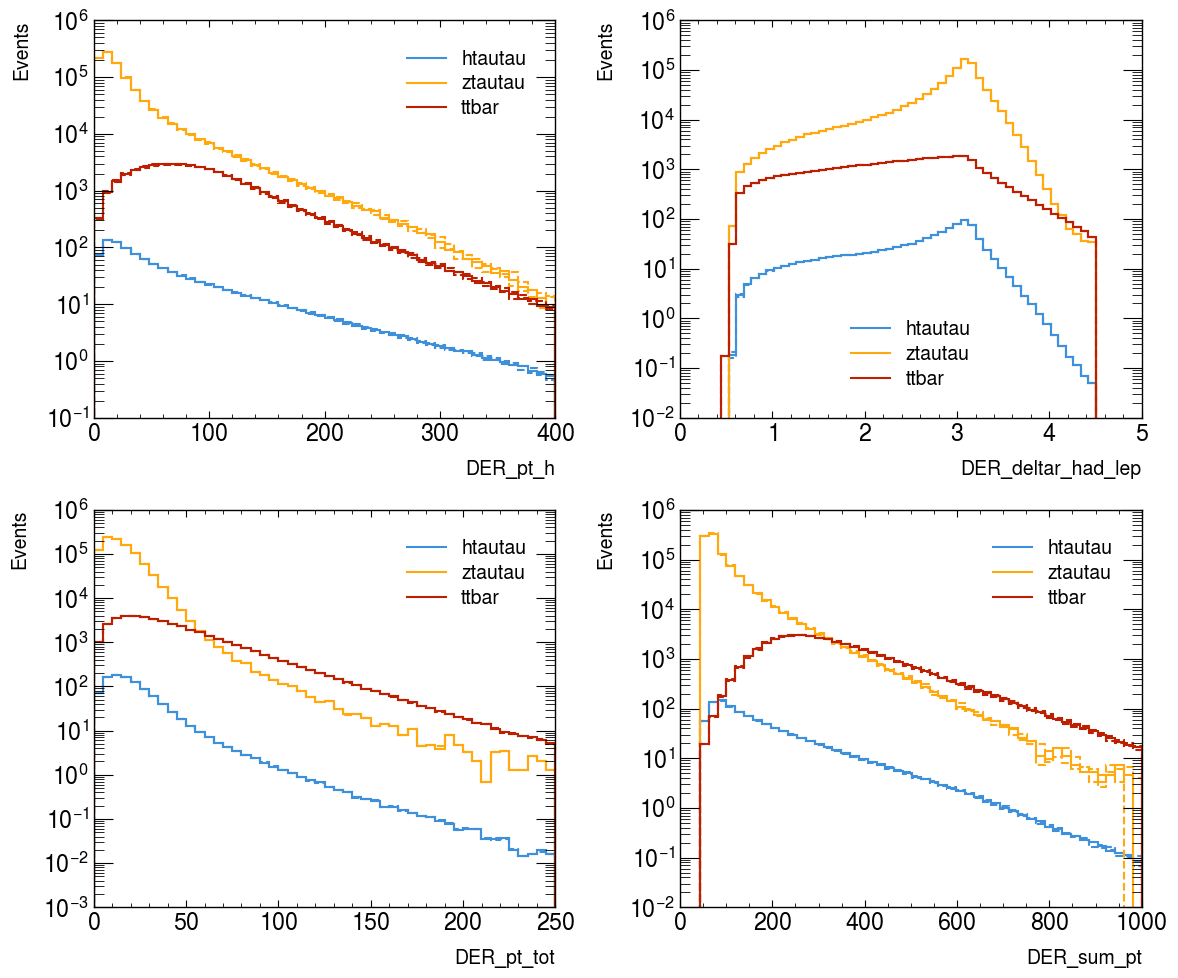

In [29]:
columns = ['DER_pt_h', 'DER_deltar_had_lep', 'DER_pt_tot', 'DER_sum_pt']
nbins = 50

xlabel_dict = {
    'PRI_lep_pt': 'lepton $p_T$ [GeV]', 
    'PRI_lep_eta': 'lepton $\\eta$ [GeV]', 
    'PRI_met': 'MET [GeV]', 
    'PRI_met_phi': 'MET $\\phi$',     
    'PRI_n_jets': '$n_{jets}$'      
}

variations_to_plot = ['nominal', 'JES_up', 'JES_dn']


fig, axes = plot_kinematic_features(
    columns=columns,
    nbins=nbins,
    variations_to_plot=variations_to_plot,
    dataset_dict=dataset_dict,
    xlabel_dict=xlabel_dict,
    labels_dict=process_to_int_labels_dict
)
plt.show()


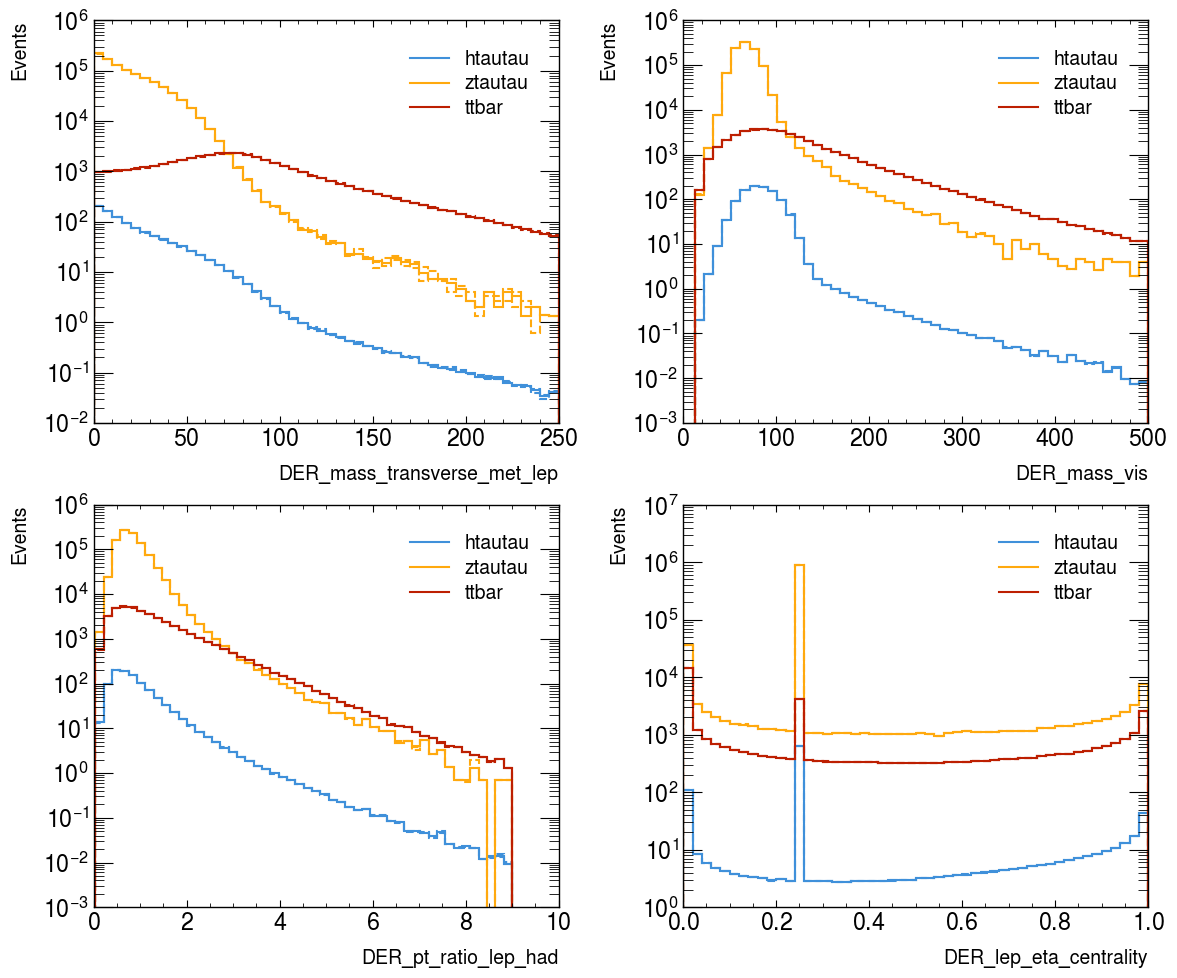

In [30]:
columns = ['DER_mass_transverse_met_lep', 'DER_mass_vis',
       'DER_pt_ratio_lep_had', 'DER_lep_eta_centrality']

nbins = 50

xlabel_dict = {
    'DER_mass_transverse_met_lep': 'DER_mass_transverse_met_lep', 
    'DER_mass_vis': 'DER_mass_vis', 
    'DER_pt_ratio_lep_had': 'DER_pt_ratio_lep_had', 
    'DER_lep_eta_centrality': 'DER_lep_eta_centrality',       
}

variations_to_plot = ['nominal', 'JES_up', 'JES_dn']


fig, axes = plot_kinematic_features(
    columns=columns,
    nbins=nbins,
    variations_to_plot=variations_to_plot,
    dataset_dict=dataset_dict,
    xlabel_dict=xlabel_dict,
    labels_dict=process_to_int_labels_dict
)
plt.show()


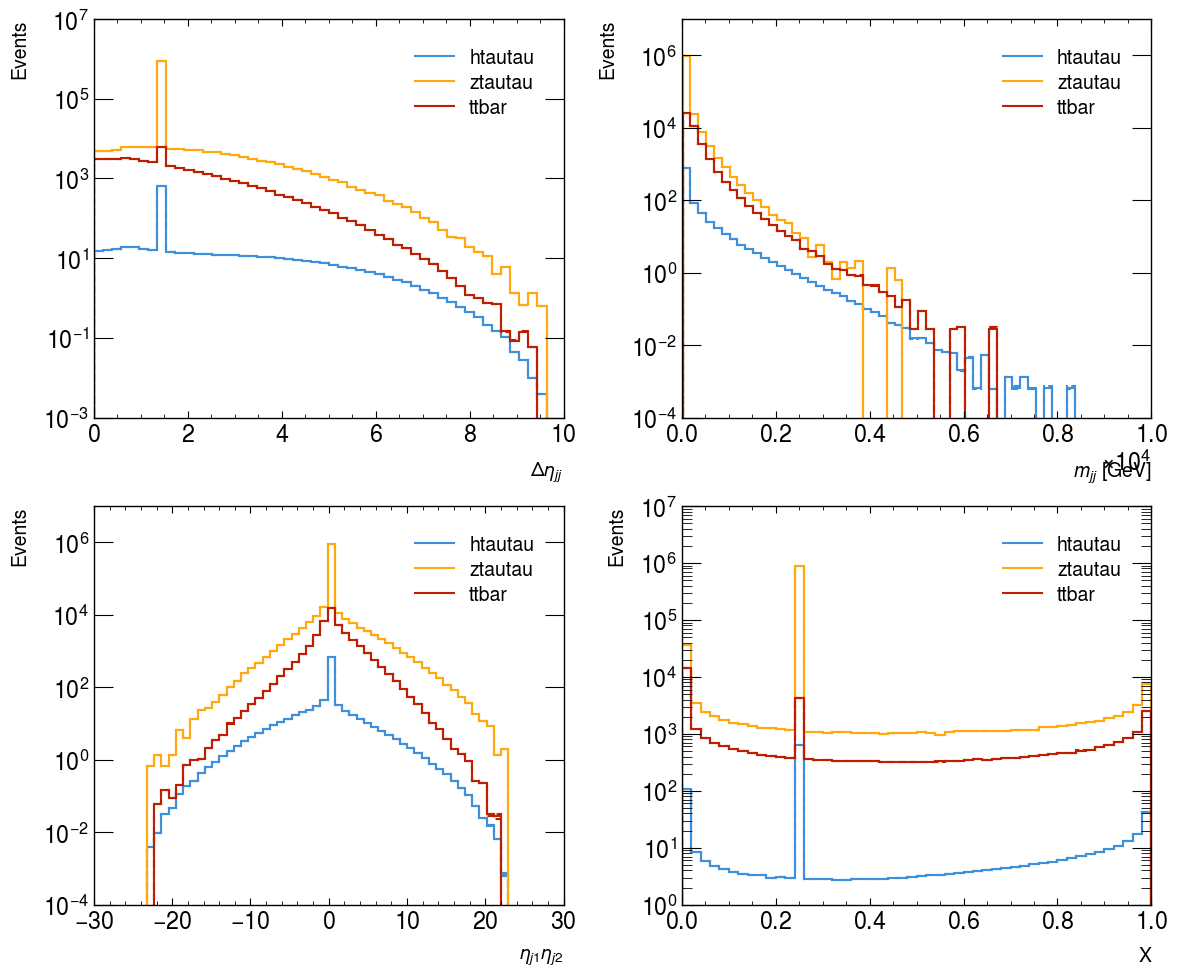

In [31]:
columns = ['DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 
           'DER_prodeta_jet_jet', 'DER_lep_eta_centrality']
nbins = 50

xlabel_dict = {
    'DER_deltaeta_jet_jet': r'$\Delta \eta_{jj}$', 
    'DER_mass_jet_jet': '$m_{jj}$ [GeV]', 
    'DER_prodeta_jet_jet': '$\eta_{j1}\eta_{j2}$', 
    'DER_lep_eta_centrality': 'X',
}

variations_to_plot = ['nominal', 'TES_up', 'TES_dn']

fig, axes = plot_kinematic_features(
    columns=columns,
    nbins=nbins,
    variations_to_plot=variations_to_plot,
    dataset_dict=dataset_dict,
    xlabel_dict=xlabel_dict,
    labels_dict=process_to_int_labels_dict
)
plt.show()

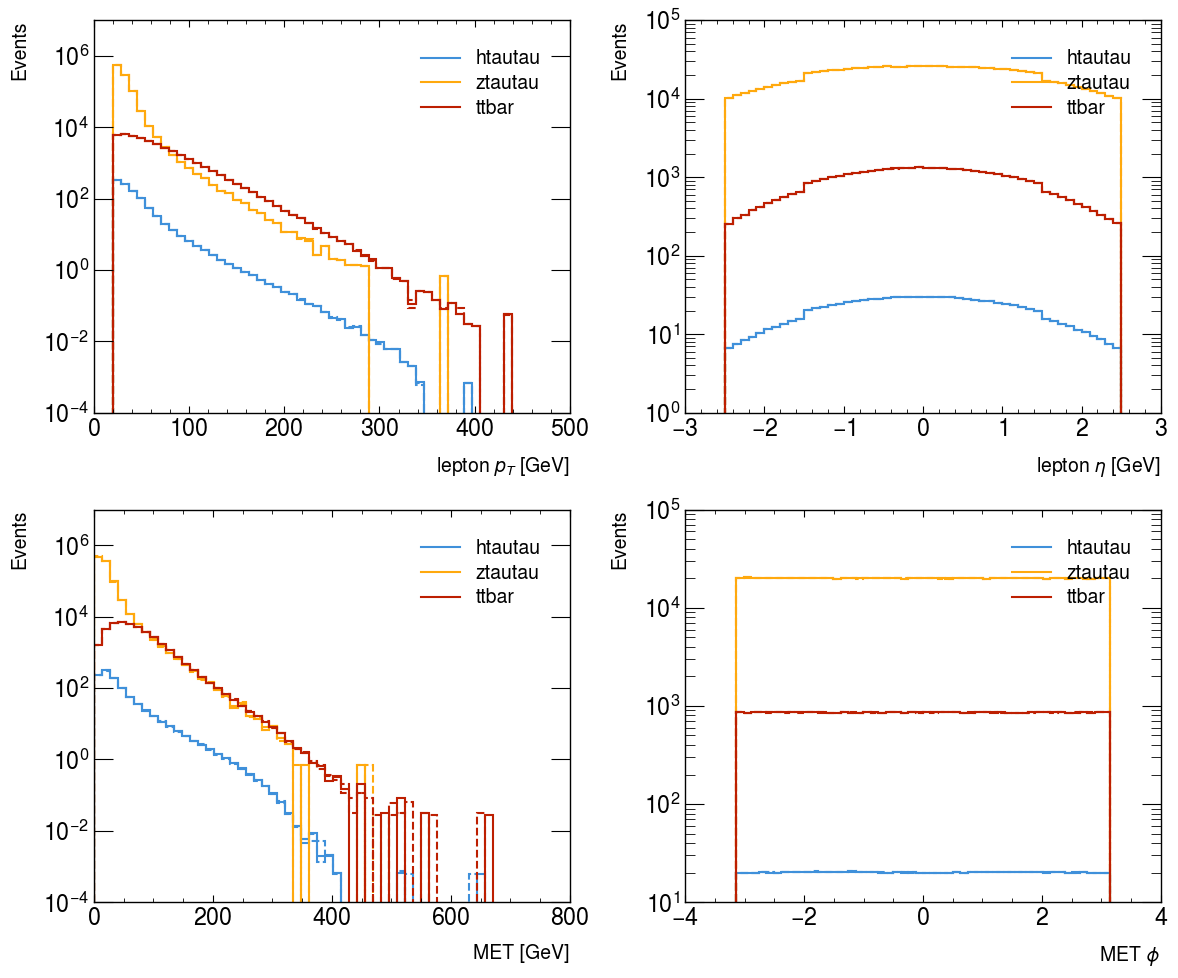

In [32]:
columns = ['PRI_lep_pt', 'PRI_lep_eta', 'PRI_met', 'PRI_met_phi']
nbins = 50

xlabel_dict = {
    'PRI_lep_pt': 'lepton $p_T$ [GeV]', 
    'PRI_lep_eta': 'lepton $\\eta$ [GeV]', 
    'PRI_met': 'MET [GeV]', 
    'PRI_met_phi': 'MET $\\phi$',     
    'PRI_n_jets': '$n_{jets}$'      
}

variations_to_plot = ['nominal', 'TES_up', 'TES_dn']


fig, axes = plot_kinematic_features(
    columns=columns,
    nbins=nbins,
    variations_to_plot=variations_to_plot,
    dataset_dict=dataset_dict,
    xlabel_dict=xlabel_dict,
    labels_dict=process_to_int_labels_dict
)
plt.show()


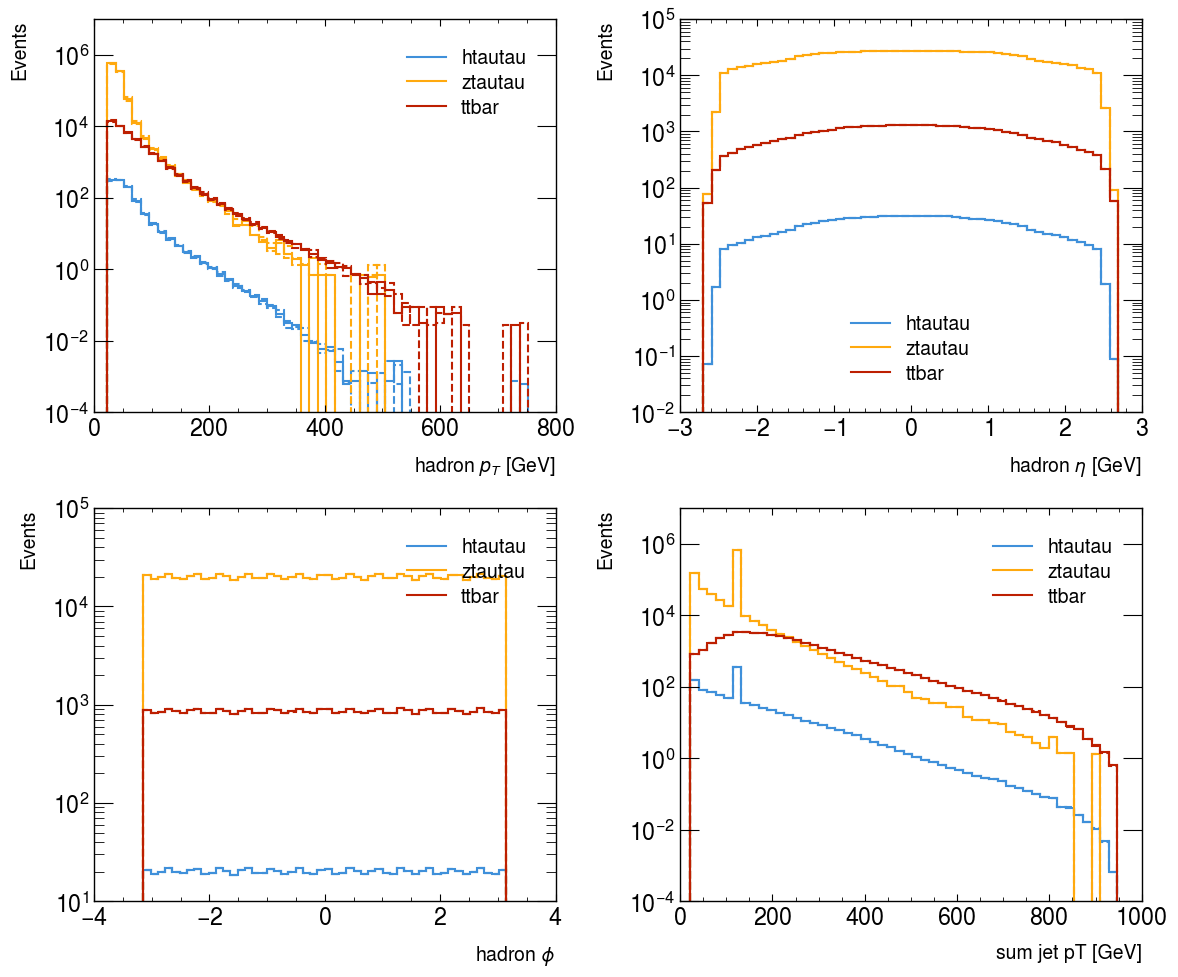

In [33]:
columns = ['PRI_had_pt', 'PRI_had_eta', 'PRI_had_phi', 'PRI_jet_all_pt']
# columns = ['PRI_had_pt', 'PRI_had_eta', 'PRI_had_phi']
nbins = 50

xlabel_dict = {
    'PRI_had_pt': 'hadron $p_T$ [GeV]', 
    'PRI_had_eta': 'hadron $\eta$ [GeV]', 
    'PRI_had_phi': 'hadron $\phi$', 
    'PRI_jet_all_pt': 'sum jet pT [GeV]',
}

variations_to_plot = ['nominal', 'TES_up', 'TES_dn']

fig, axes = plot_kinematic_features(
    columns=columns,
    nbins=nbins,
    variations_to_plot=variations_to_plot,
    dataset_dict=dataset_dict,
    xlabel_dict=xlabel_dict,
    labels_dict=process_to_int_labels_dict
)
plt.show()

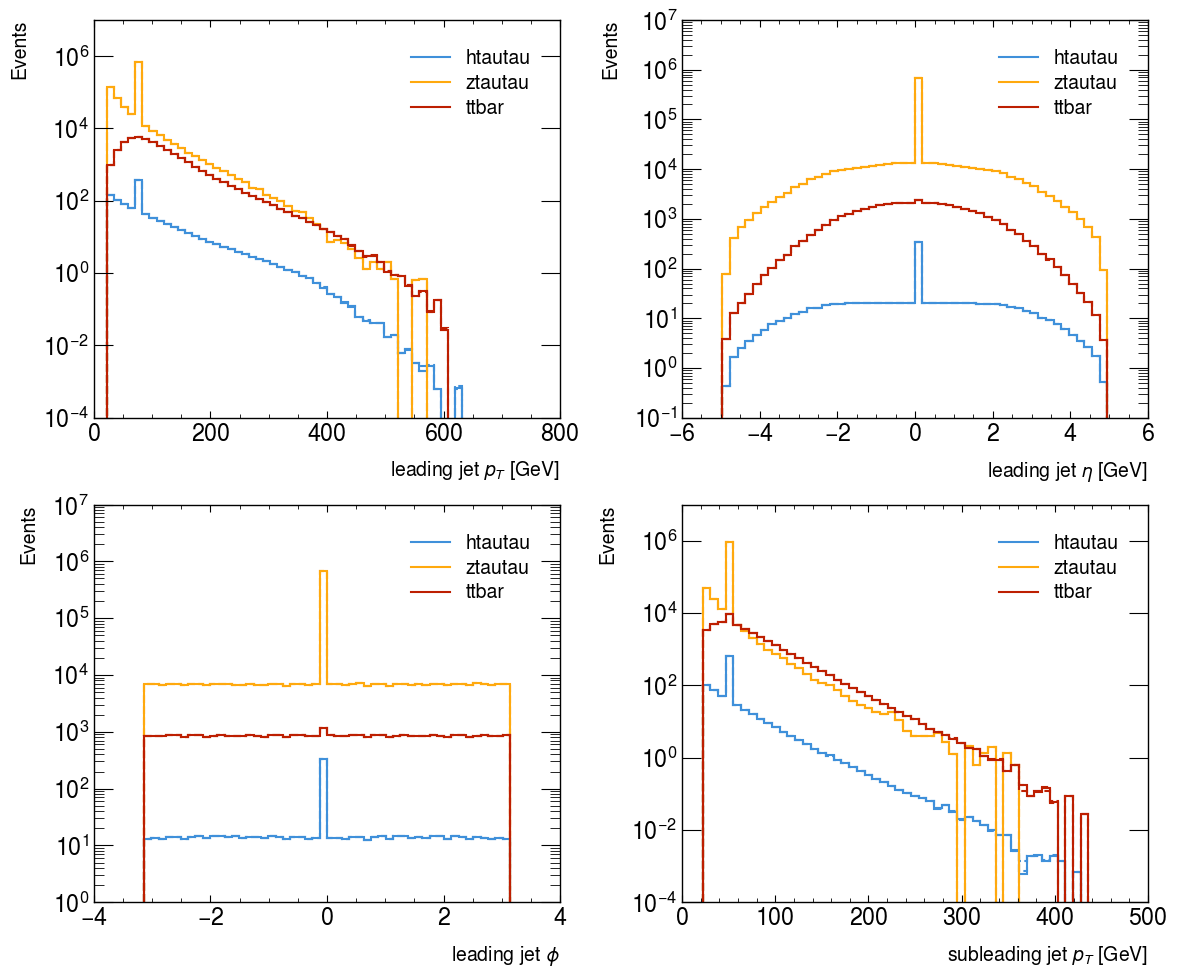

In [34]:
columns = ['PRI_jet_leading_pt', 'PRI_jet_leading_eta', 'PRI_jet_leading_phi', 'PRI_jet_subleading_pt']

# columns = ['PRI_had_pt', 'PRI_had_eta', 'PRI_had_phi']
nbins = 50

xlabel_dict = {
    'PRI_jet_leading_pt': 'leading jet $p_T$ [GeV]', 
    'PRI_jet_leading_eta': 'leading jet $\eta$ [GeV]', 
    'PRI_jet_leading_phi': 'leading jet $\phi$', 
    'PRI_jet_subleading_pt': 'subleading jet $p_T$ [GeV]',
}

variations_to_plot = ['nominal', 'TES_up', 'TES_dn']

fig, axes = plot_kinematic_features(
    columns=columns,
    nbins=nbins,
    variations_to_plot=variations_to_plot,
    dataset_dict=dataset_dict,
    xlabel_dict=xlabel_dict,
    labels_dict=process_to_int_labels_dict
)
plt.show()